# A Definitive Guide to MCMC 

Simulation is an integral piece of modern statistics; however, I'm under the impression that there is a disconnect between the theory and the application when it comes to Monte Carlo simulations. That disconnect stems from a lack of emphasis on the implementation of algorithms. I am writing this tutorial as a way to demostrate the sort of algorithimic thinking that should accompany reading a statistics textbook (i.e. how to read a textbook or acadmeic paper and convert the words into code). 

This document will be broken up into sections based on how simulations are used. We start with Monte Carlo integration, progres to estimation techniques, then turn to parameter estimation for distributions (priors and posteriors), and finally statistical models (sampling likelihood functions). Through each of these steps, the focus will be on various MCMC samplers (Metropolis-Hastings, Langevin, Gibbs, HMC) and their various strengths/weaknesses. 

In [1]:
# preamble

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from scipy import stats

## Monte Carlo Integration 

In mathematics, one of the first courses at the university level is a calculus course which focuses on integration and computing those values. Monte Carlo simulations allow us to write code in order to get estimates for those values without having to go through tedious computations (and also compute integrals that do not have closed form solutions).

To show this, let's take the following example. Say we have to compute
$$ \int_0^1\int_0^1 \cos(\sqrt{xy})dxdy  $$
We will first rewrite this as an expectation then generate some random numbers to get an estimation (as well as uncertainty bounds). 

Let $g(x,y) = \cos(\sqrt{xy})$, then we can define two random variables, $X, Y \sim_{iid} Uniform(0,1)$. An important note is that the support of the random variables has to match the bounds on the integral. That is to say, when simulating random numbers, it should cover the full extent of the integration bounds. So now we generate $M$ many samples of $X,Y$ and take the expectation to get an estimate for the integral. 

In [2]:
# set number of sims
M = 1000000
# define function
def g(x, y): return np.cos(np.sqrt(x*y))


# generate random variables
X = np.random.uniform(low=0, high=1, size=M)
Y = np.random.uniform(low=0, high=1, size=M)
# compute the values
G = g(X, Y)
# get the estimates
output = f'Estimated value: {round(np.mean(G),5)} ' \
    f'Variance: {round(np.std(G)/np.sqrt(M),5)} '
output

'Estimated value: 0.87943 Variance: 0.0001 '

What if the integral is a bit more complex? Say 
$$ \int_0^5\int_0^4 \cos(\sqrt{xy})dxdy  $$
Well in this case, rephrasing it as an expectation is slightly more involved but comes direction from the definition of the expectation (i.e. $E(X) = \sum x p(x)$). 

With $g$ same as before, $\int_0^5\int_0^4 \cos(\sqrt{xy})dxdy = \int_0^5\int_0^4 5*4*\cos(\sqrt{xy})(\frac{1}{5})(\frac{1}{4})dxdy = 5*4 \int_0^5\int_0^4 \cos(\sqrt{xy})(\frac{1}{5})(\frac{1}{4})dxdy \approx 5*4 \mathbb{E}(g(X,Y))$. With this rearrangement, we have now brought the integral into an $x * p(x)$ form and can proceed as before. 

In [3]:
# set number of sims
M = 1000000
# define function
def g(x, y): return np.cos(np.sqrt(x*y))


# generate random variables
X = np.random.uniform(low=0, high=4, size=M)
Y = np.random.uniform(low=0, high=5, size=M)
# compute the values
G = 5*4*g(X, Y)
# get the estimates
output = f'Estimated value: {round(np.mean(G),5)} ' \
    f'Variance: {round(np.std(G)/np.sqrt(M),5)} '
output

'Estimated value: -4.12532 Variance: 0.01322 '

To put some formality on the above, we can say that any intergral $I$ can be written as $I = \int g(x)dx = \int \frac{g(x)}{f(x)} f(x) dx$ where $f$ is an easy to sample function and $f(x) >0$. Then we have that $I = \mathbb{E} \left( \frac{g(x)}{f(x)} \right) \approx \frac{1}{M}\sum_{i=1}^M \frac{g(x_i)}{f(x_i)}$. This is known as **importance sampling**.

### Unnormalized Densities - The Base of Bayes 

In Bayesian inference, we often come across probability densities which are are unnormalized. That is to say, we are interested in some distribution $\pi(y)$ but all we know is that $\pi(y) = c g(y) $ where $g(y)$ is some known distribution but $c$ is not easy to find. Trivially, we can see that $c = \frac{1}{\int g(x)dx}$ but this isn't always easy to compute.

The problem at hand is to find the integral
\begin{align}
    I &= \int h(x) \pi(x)dx \\
    &= \int h(x) c g(x) dx \\
    &= \frac{\int h(x) g(x)}{\int g(x)dx}
\end{align}

After this manipulation, we now have two smaller problems (one in the numerator and the other in the denominator) which we can solve with the previous techniques. Hence 

\begin{align}
    \text{numerator} &\rightarrow \int h(x) g(x) = \int \frac{h(x)g(x)f(x)}{f(x)}dx = \mathbb{E} \left( \frac{h(x)g(x)}{f(x)} \right) \approx \frac{1}{M}\sum_{i=1}^M \frac{h(x_i)g(x_i)}{f(x_i)} \\
    \text{denominator} &\rightarrow \int g(x)dx = \int \frac{g(x)f(x)}{f(x)} = \mathbb{E} \left( \frac{g(x)}{f(x)} \right) \approx \frac{1}{M}\sum_{i=1}^M \frac{g(x_i)}{f(x_i)}
\end{align}

Finally, we combine the two results to get the value of the integral! 
$$ I \approx \frac{\text{numerator}}{\text{denominator}} = \frac{\sum_{i=1}^M \frac{h(x_i)g(x_i)}{f(x_i)}}{\sum_{i=1}^M \frac{g(x_i)}{f(x_i)}} $$ 

**NOTE**: when running this version of the importance sampler, we want to make sure that we use the same randomly generated numbers for both the numerator and denominator! 

Eg. Compute $\mathbb{E}(Y^2) $ where $Y$ has density $c y^3 \sin(y^4) \cos(y^5) I_{0<y<1} $

*Solution*: Since the variable of interest is $Y^2$, define $h(y) = y^2$ and we let $g(y) = y^3 \sin(y^4) \cos(y^5) I_{0<y<1} $. Working around the indicator, it's clear that the support of our sampling distribution should be $(0,1)$, and a natural choice is the Uniform distribution. Let's work through some of the math first: 

\begin{align}
    h(x)g(x) = y^5 \sin(y^4) \cos(y^5)
\end{align}

We use that $y^5$ as inspiration for our choice of $f$ and set $f(x) = 6y^5 I_{0<y<1} $. Note however that we decided to generate a uniform random variable so we *must* transform that to get something from $f$. Luckily this is as simple as $X \sim U(0,1) \Rightarrow Y = X^{1/6} \sim f $.  Now take the general form above and do simplify for a conveniently simple result in spite of the relatively complicated function we began with. 

\begin{align}
    I &\approx \frac{\sum_{i=1}^M \frac{h(x_i)g(x_i)}{f(x_i)}}{\sum_{i=1}^M \frac{g(x_i)}{f(x_i)}} \\
    &= \frac{\sum_{i=1}^M \sin(x_i^4) \cos(x_i^5)}{\sum_{i=1}^M \frac{\sin(x_i^4) \cos(x_i^5)}{x_i^2}}
\end{align}

In [4]:
# lets code the above
M = 1000000

X = np.random.uniform(low=0, high=1, size=M)
Y = X**(1/6)

def numerator(x): return np.sin(x**4) * np.cos(x**5)
def denominator(x): return np.sin(x**4) * np.cos(x**5) / x**2


# get the estimates
output = f'Estimated value: {round(np.mean(numerator(Y))/np.mean(denominator(Y)),5)} ' 
output

'Estimated value: 0.76624 '

## Rejection Samplers

In order to develop some intuition, we're going to go on a hunt for pi! I like to think of rejection samplers as the outcome of 3 key steps: 
1. Set your target - for us, this will be known as the target distribution or the distribution we want to sample from
2. Find something easy to sample - the target will often be very difficult to work with so we need to find something simpler to work with
3. Set a rejection condition - this is what ensures you are hitting the target

The first exercise will be to write a sampling scheme to find the pi. Recall that the area of a circle is defined by the formula $A = \pi r^2$ which we can rearrange to isolate our target $\pi = \frac{A}{r^2}$ (part 1 taken care of). We now enclose our circle in a square. For simplicty, we will work with the unit circle (seen below), so the corresponding square will be one with width $2r$. The two set of straight lines (in the x and y planes) suggest that we can sample from a uniform distribution in each plane.
\begin{align}
    X &\sim Uniform(-1,1) \\
    Y &\sim Uniform(-1,1)
\end{align}

All that remains is to set up a rejection condition and we do this by using the magnitude of the vector created by the $(X,Y)$ pair. If the magnitude is less than 1, then the point is within the circle and thus accepted, otherwise rejected. With the rejection criteria and the sampling scheme, it’s time to put it all together to get our estimate of $\pi$. This is based directly off of the proportion of accepted points $p$ which is calculated by the formula. 

$$ p = \frac{n_{accept}}{n_{accept} + n_{reject}}$$

Since we are working with the unit circle, the area of the circle is equal to $\pi$. In addition, our sampling scheme allows us to discover the proportion of points that are in the circle versus the square so we get that $A_{circle} = A_{square}p$.

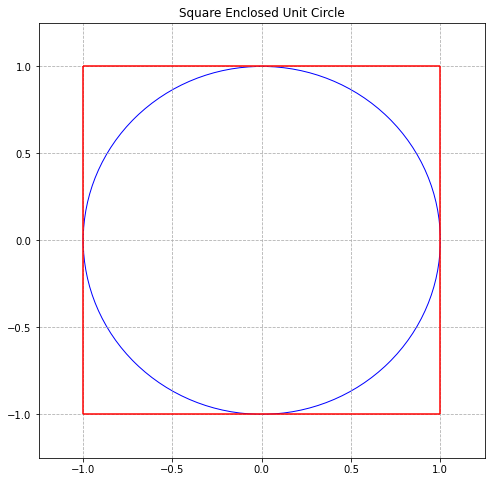

In [5]:
fig = plt.figure(figsize=(8,8))
ax = fig.add_subplot(1, 1, 1)
circ = plt.Circle((0, 0), radius=1, edgecolor='b', facecolor='None')
ax.add_patch(circ)
plt.xlim(-1.25,1.25)
plt.ylim(-1.25,1.25)
plt.title('Square Enclosed Unit Circle')
plt.grid(linestyle='--')
plt.vlines(x=(-1,1), ymin = -1, ymax=1, colors='red')
plt.hlines(y=(-1,1), xmin = -1, xmax=1, colors='red')
plt.show()

In [6]:
M = 100000

X = []
Y = []
L = []
accept = []

for ii in range(M):
    # sample X, Y
    X.append(np.random.uniform(low = -1, high = 1))
    Y.append(np.random.uniform(low = -1, high = 1))
    
    # compute magnitude 
    L.append(np.sqrt( X[ii]**2 + Y[ii]**2 ))
    
    # check rejection critera
    accept.append(1 if L[ii] <= 1 else 0)
    
P = sum(accept)/M

pi = 4*P

f'Estimated pi value: {round(pi,10)} '

'Estimated pi value: 3.14008 '

Text(0.5, 1.0, 'Sampled Circle')

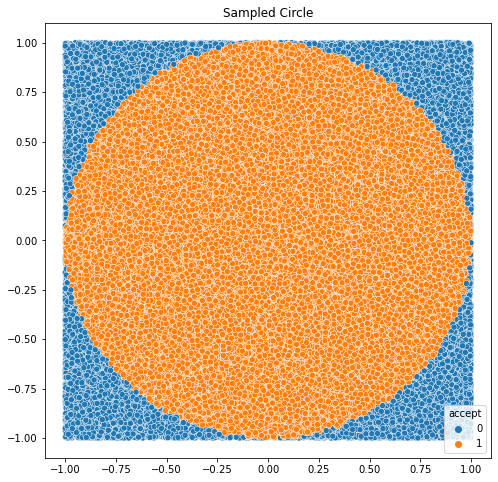

In [7]:
plt.figure(figsize=(8,8))
ax = sns.scatterplot(data = pd.DataFrame({'X': X, 
             'Y': Y, 
             'L': L,
             'accept': accept}),
               x = X,
               y = Y,
               hue = 'accept')
plt.title('Sampled Circle')

This does indeed look like a circle! Now that we have an understanding of how these samplers work, its time to move on to more complex schemes used to fit statistical models.

# Markov Chain Monte Carlo 

## First half - Markov Chains
A Markov chain is a stochastic process where the probability of each event depends *only* on the previous step in the process. This implies that at any point in time (discrete or continous), the realization of a Markov process is defined by some probability distribution known as the transition probability. Lets look at a simple example in a discrete setting. Suppose we have a frog that jumps between 3 lilypads. We want to simulate the frogs location throughout time.

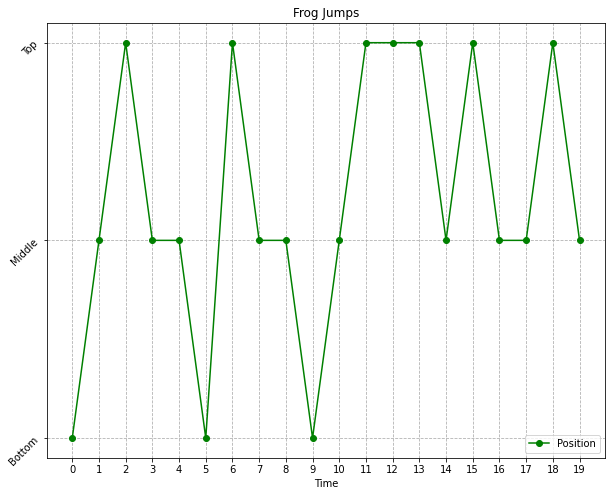

In [30]:
### Simulated Markov Chain ###

# transition probability matrix
jump_probs = [[0.2, 0.5, 0.3],
              [0.3, 0.4, 0.3],
              [0.1, 0.7, 0.2]]

initial = [1, 0, 0]  # starting on the left most lilypad
position = [1]
# where do we expect the frog to be after 10 jumps?
time = 20
jumps = [np.array(initial)]

for ii in range(1, time, 1):
    # generate 1 jump sample
    jumps.append(np.random.multinomial(1, np.matmul(jumps[ii-1], jump_probs)))
    position.append(np.matmul([1, 2, 3], jumps[ii]))

# turn to data frame and extrapolate position
fig = pd.DataFrame(position, columns=['Position']).plot(figsize=(10, 8), marker = 'o', color = 'green')
plt.title('Frog Jumps')
plt.xlabel('Time')
plt.yticks([1, 2, 3], ['Bottom', 'Middle', 'Top'], rotation=45)
plt.xticks(range(time))
plt.grid(linestyle='--')

## Second Half - Putting it all together

The premise which MCMC algorithms work on, is that we want to simulate a Markov chain which has a transition probability that is equivalent to the target distribution. Algorithms vary by changing the proposal step or the acceptance probability computation in an attempt to have the sampler converge to the target faster (more on this later). Some use gradients to "push" the sampler in the "right" direction (Langevin) , while others take an take a grid-search type approach (Gibbs). However, the principle is always the same, get that transition/proposal density to resemble the target density! 

The examples so far have been simplistic in the sense that they are all one dimensional; however, in statistics you often run into high dimensional distributions that are considerably harder to sample. This added difficulty usually comes with using more realistic models so samples from the high dimensional distributions are a necessary evil. The Metropolis algorithm is the simplest MCMC method we will focus on and is as follows: 
1. Choose some initial $X_0$ (random?)
2. Propose a next step: at time $i$ propose $\hat{x}_{i+1} \sim MVN(x_{i}, \sigma^2 I)$
    - **Note:** the proposal density is a symetric (and continous) one! This is important as it ensures the resulting chain is ergodic and reversible
3. Compute: 
    1. $p_i(\hat{x}_{i+1}|x_i) = \frac{\pi(\hat{x}_{i+1})}{\pi(x_{i} ) } = \frac{g(\hat{x}_{i+1})}{g(x_i)}$
    2. $U_i\sim Unif(0,1) $
4. Accept/reject: 
    1. $U_n < A_n$ accept and set $x_{i+1} = \hat{x}_{i+1}$
    2. $U_n > A_n$ reject and keep $x_{i+1} = x_i$ (i.e. try again)

This algorithm can also be generalized to not *require* a symetric proposal density but before we go there, let's take a look at an example of this version implemented. 

Eg. Suppose you have some mathematical model of the form $h(x_1, x_2) = e^{x_1} + x_2^2$ and your variables $X_1, X_2$ have a joint density $\pi(x_1, x_2) = k | \cos(\sqrt{x_1 x_2}) | $ for $ 0 \leq x_1 \leq 5$, $ 0 \leq x_2 \leq 4$. Find the expected value of the model. 

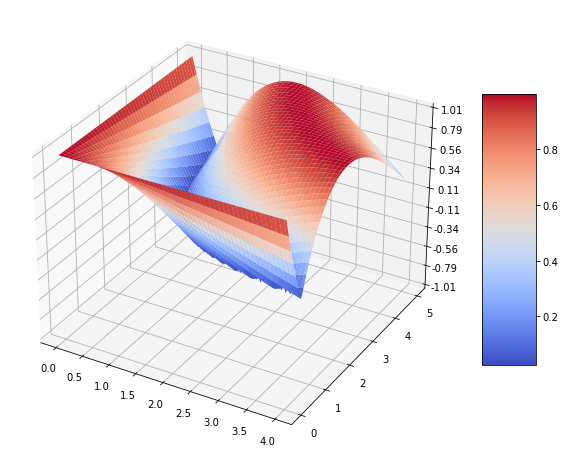

In [9]:
from matplotlib.ticker import LinearLocator
from matplotlib import cm

# define a probability function


def g(x1, x2): return np.abs(np.cos(np.sqrt(x1*x2))) 

# define a quantity of interest


def h(x1, x2): return np.exp(x1) + x2**2


# Our 2-dimensional distribution will be over variables X and Y
N = 100
X1 = np.linspace(0, 4, N)
X2 = np.linspace(0, 5, N)
# create a mesh to compute the value of our PDF over
X1, X2 = np.meshgrid(X1, X2)

Z = g(X1, X2)

# Visualize

fig, ax = plt.subplots(subplot_kw={"projection": "3d"}, figsize=(10, 10))
# Plot the surface.
surf = ax.plot_surface(X1, X2, Z, cmap=cm.coolwarm,
                       linewidth=0, antialiased=True)
# Customize the z axis.
ax.set_zlim(-1.01, 1.01)
ax.zaxis.set_major_locator(LinearLocator(10))
# A StrMethodFormatter is used automatically
ax.zaxis.set_major_formatter('{x:.02f}')

# Add a color bar which maps values to colors.
fig.colorbar(surf, shrink=0.5, aspect=5)

plt.show()

In [10]:
# define a probability function


def g(x1, x2): return np.abs(np.cos(np.sqrt(x1*x2))
                             ) if (x1 > 0 and x1 < 5 and x2 > 0 and x2 < 4) else 0

# define a quantity of interest


def h(x1, x2): return np.exp(x1) + x2**2

In [11]:
# now to compute the quanitity we are interested in using the Metropolis algo

M = 10000  # number of sims
B = 1000  # burn-in period

X = [np.random.uniform(low=0, high=4), np.random.uniform(
    low=0, high=5)]  # random initialization (2D)
sigma = 1  # scaling

x1list = []  # keep track of values
x2list = []  # keep track of values
hx = []  # proposals
num_accepts = 0

# run MCMC
for ii in range(M):
    # Proposal Step
    Y = np.random.multivariate_normal(X, np.identity(2))
    U = np.random.uniform()

    # Compute A_n
    A = g(Y[0], Y[1]) / g(X[0], X[1])

    # Check accept/reject
    if (U < A):
        X = Y  # accept proposal
        num_accepts += 1

    # store values
    x1list.append(X[0])
    x2list.append(X[1])

    hx.append(h(X[0], X[1]))

/var/folders/_q/07k1y14x087brt3tmd2bs1740000gn/T/ipykernel_17228/2597440050.py:22: RuntimeWarning: divide by zero encountered in double_scalars
  A = g(Y[0], Y[1]) / g(X[0], X[1])


In [12]:
[f'Ran the Metropolis algorithm for {M} iterations with burn-in {B} ', 
 f'Acceptance rate: {num_accepts/M}', 
 f'The mean of h is about: {np.mean(hx[B:])} ',
 f'iid standard error is: {np.std(hx[B:])/np.sqrt(M-B)} ']

['Ran the Metropolis algorithm for 10000 iterations with burn-in 1000 ',
 'Acceptance rate: 0.5037',
 'The mean of h is about: 43.181827130988125 ',
 'iid standard error is: 0.4037702915941179 ']

## Metropolis-Hasting 

Now to generalize the above, we change the proposal density so that it only requires that it is dependent on the previous step (Markov property). The trade off is that it becomes harder to compute since there is an extra piece in the denominator and numerator (previously cancelled because of the symetry). 

The outline of the algorithm is as follows: 

1. Choose some initial $x_0$ (random?)
2. Propose a next step: at time $i$ propose $\hat{x}_{i+1} \sim Q(x_{i}, \cdot)$
    - **Note:** the proposal density is a *NOT* necessarily symetric
3. Compute: 
    1. $p_i(\hat{x}_{i+1}|x_i) = \min \left\{1 , \frac{\pi(\hat{x}_{i+1}) Q(x_i | \hat{x}_{i+1} }{\pi(x_{i}) Q( \hat{x}_{i+1} | x_i) }\right\}$
        - since $Q$ is no longer symetric, they do not cancel like the in Metropolis algorithm. This is the computational hurdle with the algorithm.
    2. $U_i\sim Unif(0,1) $
4. Accept/reject: 
    1. $U_n > A_n$ accept and set $x_{i+1} = \hat{x}_{i+1}$
    2. $U_n < A_n$ reject and keep $x_{i+1} = x_i$ (i.e. try again)

We will implement an example of this in a later section! 

## Langevin Sampling 

Taking advantage of gradients. 

1. Choose some initial $X_0$ (random?)
2. Propose a next step: at time $i$ propose $\hat{x}_{i+1} \sim MVN(x_{i} + \frac{1}{2}\sigma^2 \nabla \log \pi(x_i), \sigma^2 I)$
    - **Note:** the proposal density is a symetric (and continous) one! The gradient term acts as a "push" towards the area of the sampling space where $\pi$ is increasing! 
3. Compute: 
    1. $p_i(\hat{x}_{i+1}|x_i) = \frac{\pi(\hat{x}_{i+1})}{\pi(x_{i} ) } = \frac{g(\hat{x}_{i+1})}{g(x_i)}$
    2. $U_i\sim Unif(0,1) $
4. Accept/reject: 
    1. $U_n < A_n$ accept and set $x_{i+1} = \hat{x}_{i+1}$
    2. $U_n > A_n$ reject and keep $x_{i+1} = x_i$ (i.e. try again)


## Gibbs Sampling

# From Simulation to Inference

Up to this point, all of the examples we have looked at have been in the context of evaluating expectations. These techniques are useful when trying to estimate specific quantities which may be difficult (or impossible) to compute with traditional methods. However, as applied statisticians, we are particularly interested in statistical models and how to fit those models. MCMC techniques are necessary in order to fit Bayesian models. In contrast to their frequentist counterparts, Bayesian models make probabalistic arguments about the world. This is done by making some assumptions on how observed data *could* have been generated. Through Bayes' theorem, we can relate observed data to parameters in the hopes that the data will reduce the uncertainty for possible parameter values (sadly this is not guaranteed by that just means you made a poor model choice). 

Think of a model as a mathematical object defined by a set of parameters $\theta$. Bayesian philosophy dictates that data depends on these parameters, but Bayesian inference is the process of finding the value of those parameters from the data (i.e. the parameter depends on the data). Mathematically, we can formulate this relation through Bayes' Theorem for statistical models: 
$$ \pi(\theta) = p(\theta | Y  = y) = \frac{ \mathcal{L}(Y | \theta) p(\theta)}{p(Y)} = c   \mathcal{L}(Y | \theta) p(\theta)$$ 
where
- $\theta $ is the parameter vector 
- $Y$ is the random variable corresponding to the data and $y$ are realizations (observed data)
- $p(\theta)$ is the prior distribution on the model parameters (values it *could* take)
- $ \mathcal{L}(Y | \theta) $ is the likelihood
- $ p(Y)$ is the marginal likelihood 
- $p(\theta | Y  = y)$ is the posterior distribution

Tying this back in with the previous sections, our target it the posterior distribution of $\theta$ but with a noteable difference being that we now don't know exactly what that distribution is (but we can make some reasonable assumption based on EDA). 

## A few examples 

1. Is this coin fair? 
    Based on an observed dataset, can we determine whether or not a coin is fair --- Spoiler alert: YES! 

In [47]:
# The data
Y = np.random.binomial(n = 1, p = 0.7, size = 20)
pd.DataFrame(Y, columns=['Result']).head()

,Result
0,1
1,1
2,1
3,0
4,1


Let's specify a model to perform inference on. Since a coin flip only has 2 outcomes, we need a model that outputs a binary random variable (ex. Bernoulli). 
\begin{align}
    Y &\sim Bernoulli(\theta) \\
    \theta &\sim Beta(1,1)
\end{align}
The model is listed on the top line, with the prior information on the model parameter on the second line. Let's run a Metropolis alogirthm to perform the inference.

In [58]:
# step 1: define the posterior
def posterior(theta, Y, a=1, b=1):
    if (0 <= θ <= 1):
        prior = stats.beta(a, b).pdf(theta)
        likelihood = stats.bernoulli(theta).pmf(Y).prod()
        prob = likelihood * prior
    else:
        prob = -np.inf
    return prob

In [107]:
# step 2: define constants

n_iters = 1000
can_sd = 0.5

a = b = 1
# 0. initialization
theta = 0.5
trace = {"values": np.zeros(n_iters)}
p2 = posterior(theta, Y, a, b)

In [136]:
for ii in range(n_iters):
    # 1. Proposal step
    theta_prop = stats.norm(theta, can_sd).rvs(1)

    # 2. Compute acceptance probability
    p1 = posterior(theta_prop, Y, a, b)
    pa = p1 / p2
    
    if pa > stats.uniform(0, 1).rvs(1):
        theta = theta_prop
        p2 = p1
    
    trace['values'][ii] = theta

<AxesSubplot:xlabel='Frequency'>

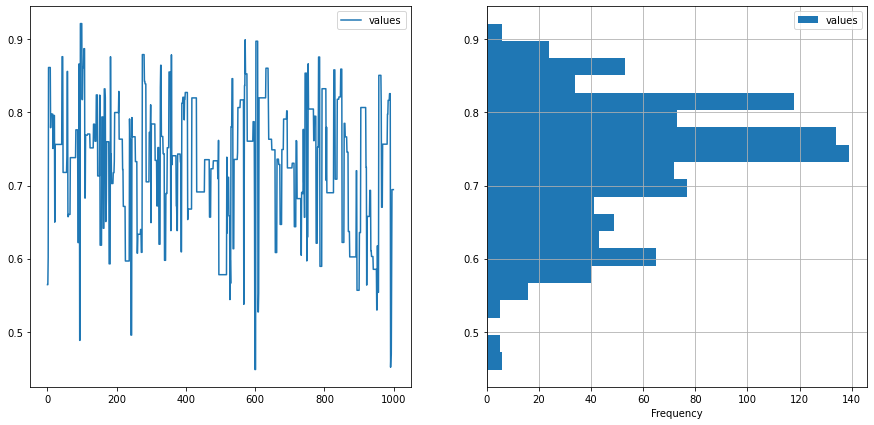

In [137]:
fig = plt.figure(figsize=(15,7))
# Divide the figure into a 2x1 grid, and give me the first section
ax1 = fig.add_subplot(121)
# Divide the figure into a 2x1 grid, and give me the second section
ax2 = fig.add_subplot(122)

pd.DataFrame(trace).plot( ax=ax1,)
pd.DataFrame(trace).plot( ax=ax2, grid = True, kind = 'hist', orientation = 'horizontal', bins = 20)